In [6]:
from google.cloud import bigquery
import pandas as pd

# Muestra de datos

In [10]:

master_table = "unir-predictiv0-andina-espana.datacomex.comex_comunidad_andina_modelo"

def get_bigquery_data(query) -> pd.DataFrame:
    client = bigquery.Client() 
    query_job = client.query(query)
    return query_job.to_dataframe()

In [11]:
query = f"""
    SELECT *
    FROM {master_table}
    WHERE anio = 2024 AND mes = 6
"""

df = get_bigquery_data(query)

In [12]:
df.count()

fecha                  33725
anio                   33725
mes                    33725
tipo_movimiento_cod    33725
tipo_movimiento        33725
estado_transaccion     33725
cod_pais               33725
nombre_pais            33725
cod_provincia          33725
nombre_provincia       33725
cod_comunidad          33725
nombre_comunidad       33725
nivel_taric            33725
cod_taric              33725
descripcion_taric      33725
euros                  33725
dolares                33725
kilogramos             33725
dtype: int64

In [14]:
df.to_csv('comex.csv', index=False, encoding='utf-8', header=True)

# Modelo

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [36]:
query = f"""
    SELECT kilogramos, dolares, cod_taric, cod_pais, tipo_movimiento_cod    
    FROM {master_table}
    WHERE nivel_taric = '1'
"""

df = get_bigquery_data(query)

# Ejemplo de transformación logarítmica
df['dolares'] = np.log1p(df['dolares'])  # log(1 + dolares)
df['kilogramos'] = np.log1p(df['kilogramos'])


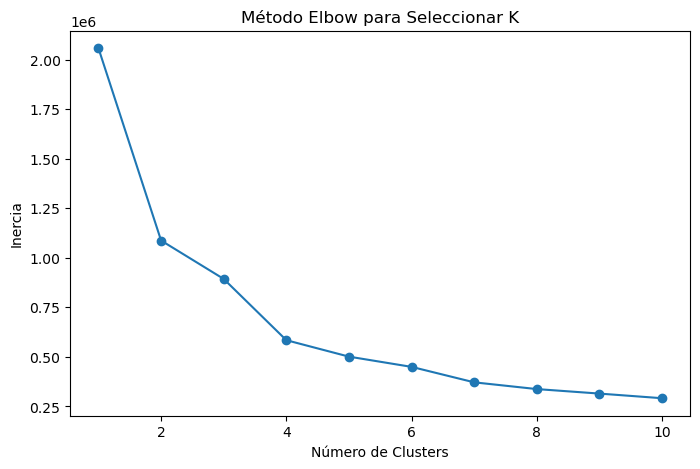

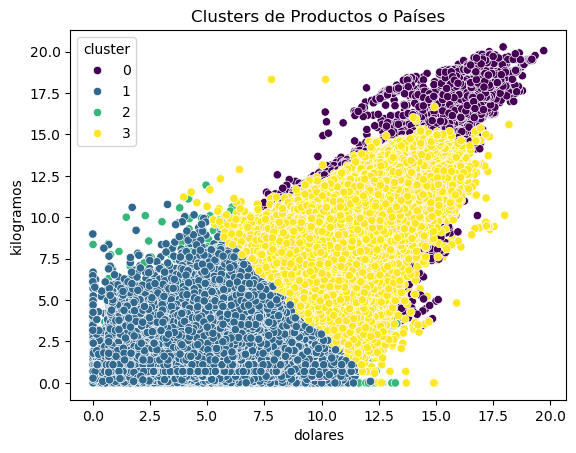

In [37]:

features = df[['dolares', 'kilogramos', 'cod_taric', ]]

# Escalado de las características
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determinación del número óptimo de clusters (Método Elbow)
inertia = []
range_clusters = range(1, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Gráfico del método Elbow
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método Elbow para Seleccionar K')
plt.show()

# Entrenamiento del modelo K-Means con el número óptimo de clusters
optimal_k = 4  # Ajusta esto según el gráfico de Elbow
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)

# Visualización de los clusters
sns.scatterplot(data=df, x='dolares', y='kilogramos', hue='cluster', palette='viridis')
plt.title('Clusters de Productos o Países')
plt.show()


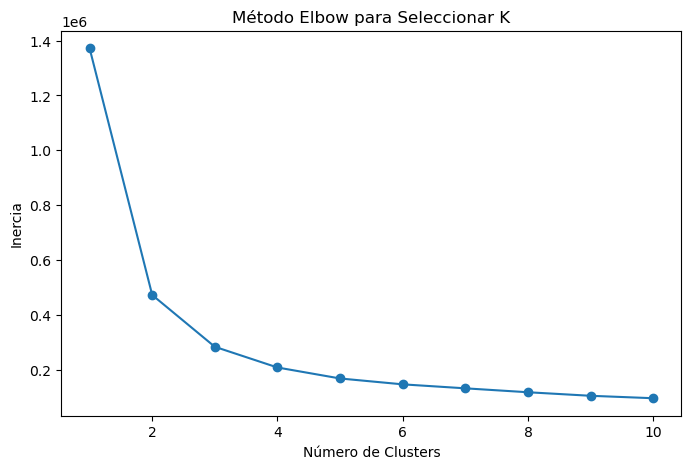

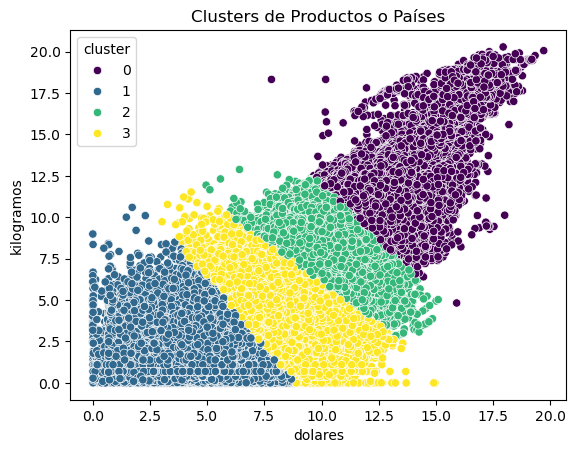

In [38]:
# Selección de características relevantes para K-Means (añadir más columnas)
features = df[['dolares', 'kilogramos']]

tipo_movimiento_encoded = pd.get_dummies(df['tipo_movimiento_cod'], prefix='tipo_movimiento_cod')
cod_taric_encoded = pd.get_dummies(df['cod_taric'], prefix='cod_taric')
cod_pais_encoded = pd.get_dummies(df['cod_pais'], prefix='cod_pais')



features = pd.concat([features, tipo_movimiento_encoded], axis=1)
features = pd.concat([features, cod_taric_encoded], axis=1)
features = pd.concat([features, cod_pais_encoded], axis=1)

# Escalado de las características
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Entrenamiento del modelo K-Means con el número óptimo de clusters
optimal_k = 3  # Ajusta este valor según el gráfico Elbow
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)


features = df[['dolares', 'kilogramos' ]]


tipo_movimiento_encoded = pd.get_dummies(df['tipo_movimiento_cod'], prefix='tipo_movimiento_cod')



# Escalado de las características
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determinación del número óptimo de clusters (Método Elbow)
inertia = []
range_clusters = range(1, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Gráfico del método Elbow
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método Elbow para Seleccionar K')
plt.show()

# Entrenamiento del modelo K-Means con el número óptimo de clusters
optimal_k = 4  # Ajusta esto según el gráfico de Elbow
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)

# Visualización de los clusters
sns.scatterplot(data=df, x='dolares', y='kilogramos', hue='cluster', palette='viridis')
plt.title('Clusters de Productos o Países')
plt.show()



In [39]:
# Validación de la estandarización
scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
print(scaled_df.describe())


            dolares    kilogramos
count  6.859940e+05  6.859940e+05
mean  -2.757676e-16 -1.352322e-16
std    1.000001e+00  1.000001e+00
min   -3.312327e+00 -1.915556e+00
25%   -6.939152e-01 -7.997502e-01
50%    1.051264e-01  4.506727e-02
75%    7.197750e-01  8.324795e-01
max    3.887639e+00  3.839369e+00


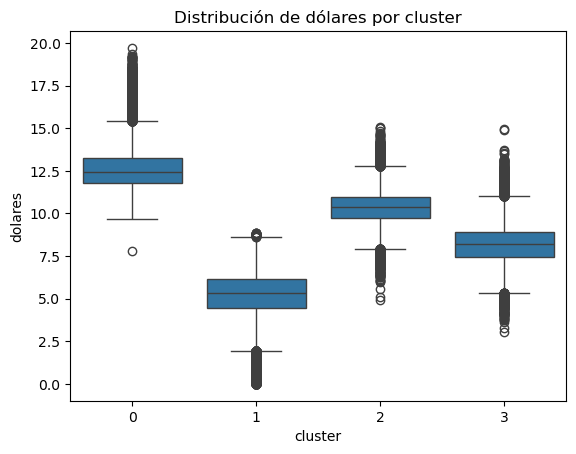

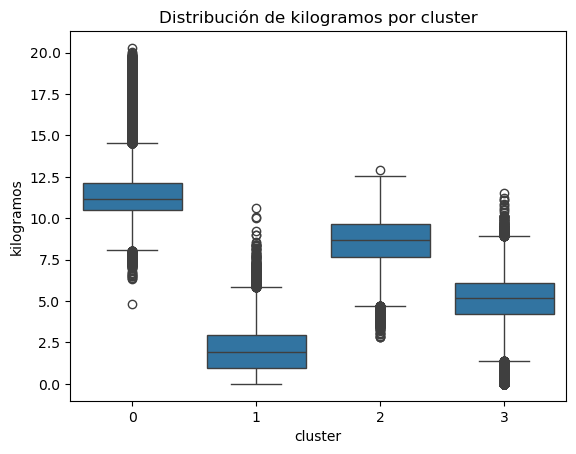

In [40]:
# Boxplot para dólares por cluster
sns.boxplot(data=df, x='cluster', y='dolares')
plt.title('Distribución de dólares por cluster')
plt.show()

# Boxplot para kilogramos por cluster
sns.boxplot(data=df, x='cluster', y='kilogramos')
plt.title('Distribución de kilogramos por cluster')
plt.show()


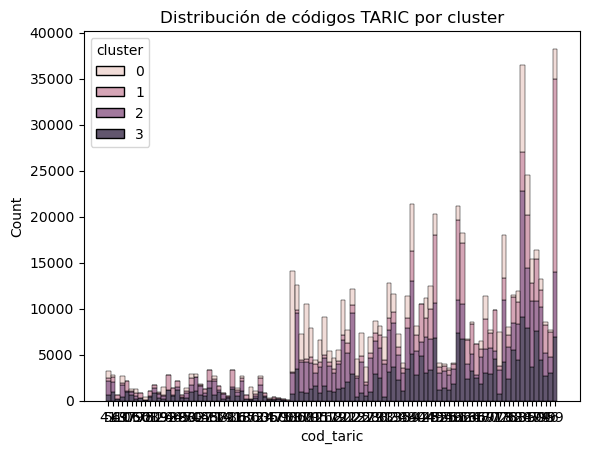

In [43]:
# Histograma de códigos TARIC por cluster
sns.histplot(data=df, x='cod_taric', hue='cluster', multiple='stack', bins=30)
plt.title('Distribución de códigos TARIC por cluster')
plt.show()
